# Exercise 3
### Group "21stCenturyBoys": Mattia Ceravolo, Lorenzo Borella, Samuele Lipani, Marco Giunta.

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
import random
from math import log, sin, pi
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D

## CNN for DNA sequences

In [5]:
fname="DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter = ",",
                    usecols=(0,1), unpack=True, dtype=str)

N_dna=len(sy) #number of samples
Ls=len(sx[0]) #length of each string

perc_train=0.8
N_train_dna=int(N_dna*perc_train)
N_test_dna=N_dna-N_train_dna

#one-hot encoding to associate each character to a sequence of 0 and 1
Q = ["A","C","G","T"]
Nc=4
onehc={Q[i]:i for i in range(Nc)} #one-hot encoding
print(onehc)

y_dna = sy.astype(int) #data conversion 
L_dna = Ls*Nc #length of input layer
x_dna = np.zeros((N_dna,L_dna)) #every row is an input

for n in range(N_dna): #for each sample
    for i in range(Ls): #for each character
        x_dna[n][i*4 + onehc[sx[n][i]]] = 1
        
x_dna = x_dna.reshape((x_dna.shape[0],int(x_dna.shape[1]/4),4,1))

#split tain/test-validation
(x_train_dna,y_train_dna) = (x_dna[:N_train_dna],y_dna[:N_train_dna]) #TRAINING SET
(x_test_dna,y_test_dna)  = (x_dna[N_train_dna:],y_dna[N_train_dna:]) #TEST SET

print("Fraction of data=1 in the training:",y_train_dna.sum()/N_train_dna)
print("Fraction of data=1 in the test:",y_test_dna.sum()/N_test_dna)

{'A': 0, 'C': 1, 'G': 2, 'T': 3}
Fraction of data=1 in the training: 0.24333333333333335
Fraction of data=1 in the test: 0.25833333333333336


In [8]:
from keras import regularizers, initializers
from keras.optimizers import SGD 

reg = regularizers.l1(0.0001) #lasso, with 0.1 doesn't converge
#ini = initializers.RandomNormal(mean=0,stddev=0.5) #initialization of the weigths
opt1 = SGD(learning_rate=0.1,
           momentum=0.9,
           nesterov=True) 


def compile_model_dna(optimizer=opt1,activation="relu",dropout_rate=0, x_f = 4,n_f = 5):
    
    # create the mode
    model = Sequential()
    
    model.add(Conv2D(filters=n_f,kernel_size=(6,4), 
                 activation="relu",
                 input_shape=(16,4,1),
                 kernel_regularizer=reg
                 #kernel_initializer=ini
                 ))
    #model.add(AveragePooling2D((2,1))) #first and only pooling; from 5 numbers to 1

    #model.add(Conv2D(filters=25, kernel_size=(4,1), activation="relu"))
    model.add(Flatten())
    model.add(Dense(x_f*L_dna,activation=activation)) 
    model.add(Dense(L_dna/2,activation=activation))
    model.add(Dense(L_dna/4,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    
    # compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [10]:
def fit_and_plot(model = compile_model_dna(), x_train = x_train_dna, y_train = y_train_dna, x_test = x_test_dna, y_test = y_test_dna, epochs = 50, batch_size =20):
    
    fit = model.fit(x_train, y_train, 
               epochs=epochs, batch_size=batch_size,
               validation_data=(x_test,y_test),
                shuffle=True)
    #Plot the results

    score = model.evaluate(x_test, y_test, verbose=1)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # look into training history

    # summarize history for accuracy
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # summarize history for loss
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

After a grid search similar to the one of the previous exercise we obtained the following parameters

Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 0.5453 - accuracy: 0.7423 - val_loss: 0.3728 - val_accuracy: 0.7983
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.3129 - accuracy: 0.8502 - val_loss: 0.1990 - val_accuracy: 0.9233
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.1424 - accuracy: 0.9523 - val_loss: 0.0632 - val_accuracy: 0.9867
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0760 - accuracy: 0.9856 - val_loss: 0.0966 - val_accuracy: 0.9817
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.9888 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 

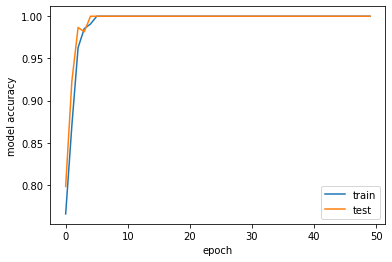

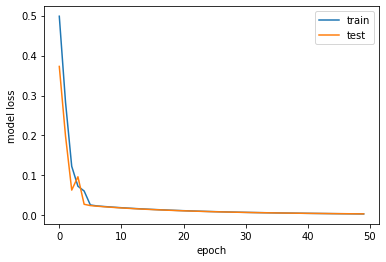

In [11]:
fit_and_plot(model = compile_model_dna(dropout_rate=0, x_f = 12,n_f = 75), epochs = 50, batch_size =20)

### Confusion matrix for DNA sequences' network

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.set_printoptions(precision=2, suppress=True)

counts_dna = [len(y_test_dna)-np.sum(y_test_dna, axis=0),np.sum(y_test_dna, axis=0)]
print("Labels and frequencies in test set: ", counts_dna)
model_dna = compile_model_dna(dropout_rate=0, x_f = 12,n_f = 75)
model_dna.fit(x_train_dna, y_train_dna, 
               epochs=50, batch_size=20,
               validation_data=(x_test_dna,y_test_dna),
                shuffle=True, verbose=0)

predict_dna = (model_dna.predict(x_test_dna)).round()

confusion_dna = confusion_matrix(y_test_dna, predict_dna)/counts_dna

Labels and frequencies in test set:  [445, 155]


Text(76.2, 0.5, 'predicted label')

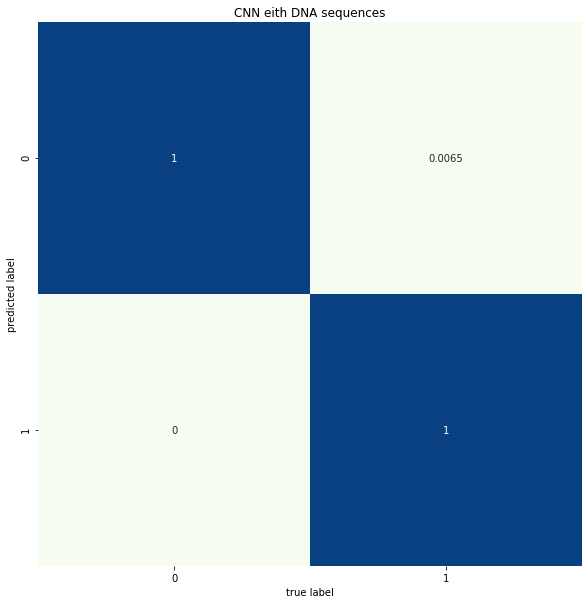

In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1 = sns.heatmap(confusion_dna, square=True, annot=True, cbar=False, cmap='GnBu', xticklabels=[0,1], yticklabels=[0,1], ax=ax1)
ax1.set_title('CNN eith DNA sequences')
ax1.set_xlabel('true label')
ax1.set_ylabel('predicted label')

As expected when we saw the accuracy of the model converginf to one, the confusion matrix is $\approx$ identity. It means that thanks to convolutional architecture and pooling the CNN classifies correctly all the sequences recognizing the presence of the "key".

## Part 1 (Convolutional neural network)

In [14]:
random.seed(12345)

step = lambda DX, bias: round((log(random.random()) * DX) * 2*(random.randint(0,1)-0.5) + bias)
def pattern(y,z,a,i):
    """...."""
    return round((3-2*y) * a * sin((pi*i)/z))

random.seed(12345)
#pattern features
Z = 12
A = 500

#data
N = 10000
L = 60

DX = 50
bias = 5

y = [0] * N # a zeros array and we don't want here to use numpy 
x = [[0] * L for i in range(N)]

# generating the x samples 


for n in range(N):
    if n > 0 : 
        x[n][0] = x[n-1][-1]
    for j in range(1,L):
        x[n][j] = x[n][j-1] + step(DX,bias)

    y[n] = n%3
    if y[n] > 0:
        j0 = random.randint(0,L-1-Z)
        for j in range(Z):
            x[n][j0+j] += pattern(y[n],Z,A,j)

In [15]:
x = np.array(x)
N = len(x)
print(N)

# these categories are going to the matrix useful for categorical cross entropy
categ = np.array(y)
N_categ = 3 # essendo il numero di colonne dell'array delle categorie 
y = np.zeros((N,N_categ))

mask = np.array([[n,categ[n]] for n in range(len(categ))])
y[mask[:,0],mask[:,1]] = 1
print(y[0],'\n',y[1],'\n',y[2])

perc_train = 0.8
N_train = int(N * perc_train)
N_val = N - N_train

xm = np.mean(x, axis=1).reshape(N,-1)
x = x - xm

std = np.std(x, axis=1).reshape(N,-1)
x = x / std

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

10000
[1. 0. 0.] 
 [0. 1. 0.] 
 [0. 0. 1.]


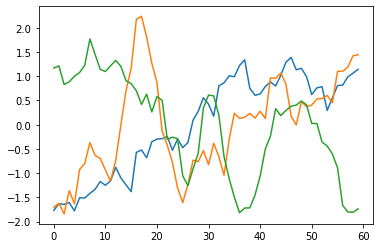

In [16]:
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

## Data reshaping

In [17]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

## Convolutional NN

In [18]:
from keras import initializers, regularizers
reg = regularizers.l1(0.01) # for the lambda in lasso regularization
np.random.seed(12345)
# it draws from a normal distribution
ini = initializers.RandomNormal(mean=0, stddev= 0.05)

model = Sequential()
model.add(Conv1D(filters=5, kernel_size=11,
          kernel_regularizer = reg,
          kernel_initializer = ini,
          activation = "relu",
          input_shape = input_shape
          ))

model.add(AveragePooling1D(5))
model.add(Conv1D(filters=5, kernel_size=7, activation="relu"))
model.add(Flatten())
model.add(Dense(10,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(N_categ, activation="softmax"))

print(model.summary())

from keras import optimizers
opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten_5 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                

In [20]:
batch_size = 250
epochs = 250

fit = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=2, shuffle=True)

0.7760 - val_loss: 0.6390 - val_accuracy: 0.7610
Epoch 53/250
32/32 - 0s - loss: 0.6295 - accuracy: 0.7670 - val_loss: 0.6542 - val_accuracy: 0.7475
Epoch 54/250
32/32 - 0s - loss: 0.6311 - accuracy: 0.7688 - val_loss: 0.6351 - val_accuracy: 0.7715
Epoch 55/250
32/32 - 0s - loss: 0.6300 - accuracy: 0.7682 - val_loss: 0.6269 - val_accuracy: 0.7730
Epoch 56/250
32/32 - 0s - loss: 0.6181 - accuracy: 0.7755 - val_loss: 0.6310 - val_accuracy: 0.7630
Epoch 57/250
32/32 - 0s - loss: 0.6279 - accuracy: 0.7707 - val_loss: 0.6280 - val_accuracy: 0.7670
Epoch 58/250
32/32 - 0s - loss: 0.6117 - accuracy: 0.7704 - val_loss: 0.6242 - val_accuracy: 0.7695
Epoch 59/250
32/32 - 0s - loss: 0.6169 - accuracy: 0.7719 - val_loss: 0.6303 - val_accuracy: 0.7755
Epoch 60/250
32/32 - 0s - loss: 0.6298 - accuracy: 0.7678 - val_loss: 0.6638 - val_accuracy: 0.7590
Epoch 61/250
32/32 - 0s - loss: 0.6155 - accuracy: 0.7753 - val_loss: 0.6335 - val_accuracy: 0.7605
Epoch 62/250
32/32 - 0s - loss: 0.6310 - accuracy: 

63/63 [==============================] - 0s 756us/step - loss: 0.7152 - accuracy: 0.7460

Test loss: 0.7151896357536316
Test accuracy: 0.7459999918937683


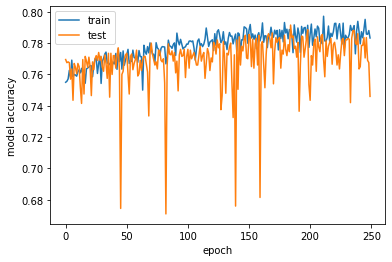

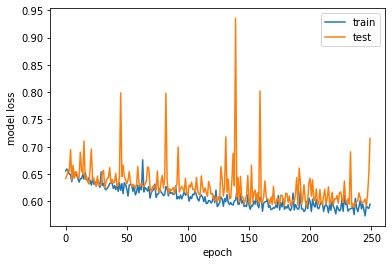

In [21]:
#Plot the results

score = model.evaluate(x_val, y_val, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Visualizing the confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

# per la confusion matrix è necessario contare quante volte le labels compaiono all'interno dei nostri dati. Vista la scelta di usare delle labels non unidimensionali ma array di dimensione pari al numero di categorie per ogni sample posso fare: 
# per contare quante volte un sample è stato classificato nella prima categoria prendo la prima colonna dell'array y_val e scrivo np.sum(y_val[0]), in questo modo essendo y_val[0] un array di zero e uno quelle volte in cui il sample appartiene alla prima categoria allora comparirà un "uno" altrimenti uno zero. Sommando gli elementi dell'array conto dunque quanti samples rientrano nella prima categoria. Lo steso discorso per le altre due.

counts = np.sum(y_val, axis=0)
print("Labels and frequencies in test set: ", counts)

confusion_nn = confusion_matrix(y_val.argmax(axis=1), model.predict(x_val).argmax(axis=1))/counts[:,None]
# counts[:,None] altro non è che un modo per scrivere l'array dei conteggi con una dimensione in più. Esso infatti nasce come array unidimensionale mentre lo vorremmo trasporre quindi tante righe e una colonna per poter usare il broadcasting e dividere la confusion matrix per counts. Il procedimento è identico ad usare np.newaxis che è effettivamente un None

labels = ["absent","negative","positive"] # sono le tre categorie 

Labels and frequencies in test set:  [667. 666. 667.]


Text(76.2, 0.5, 'predicted label')

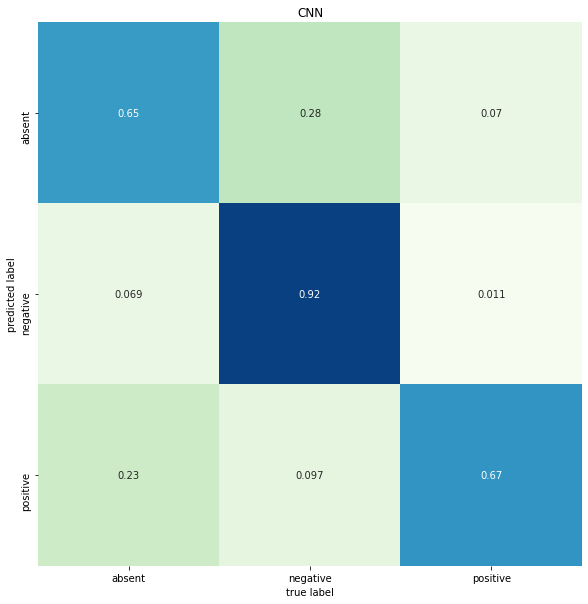

In [24]:
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1 = sns.heatmap(confusion_nn, square=True, annot=True, cbar=False, cmap='GnBu', xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title('CNN')
ax1.set_xlabel('true label')
ax1.set_ylabel('predicted label')

## Part 2 (Changing the signal to noise ratio)

The scope of this part is, changing the amplitude of the signal, watching how the network varies its training on the samples. Decreasing the amplitude A makes more difficult for the network to understand the pattern inside the signal.

In [25]:
#A = 50
random.seed(12345)
# generating the x samples 

def traj(x,y,A,N=10000,L=60,DX=50,bias=5,Z=12):
    for n in range(N):
        if n > 0 :
            x[n][0] = x[n-1][-1]
        for j in range(1,L):
            x[n][j] = x[n][j-1] + step(DX,bias)
        y[n] = n%3
        if y[n] > 0:
            j0 = random.randint(0,L-1-Z)
            for j in range(Z):
                x[n][j0+j] += pattern(y[n],Z,A,j)
    #categ1 = np.array(y1)
    categ1 = y
    N_categ = 3 # essendo il numero di colonne dell'array delle categorie 
    y2 = np.zeros((N,N_categ))

    mask1 = np.array([[n,categ1[n]] for n in range(len(categ1))]).astype(int)
    y2[mask1[:,0],mask1[:,1]] = 1
    #print('These are the labels encoded in a categorical way to use multiclass classification and cross entropy loss','\n',y2[0],'\n',y2[1],'\n',y2[2])

    perc_train = 0.8
    N_train = int(N * perc_train)
    N_val = N - N_train

    xm = np.mean(x1, axis=1).reshape(N,-1)
    x = x - xm

    std = np.std(x1, axis=1).reshape(N,-1)
    x = x / std
    return x,y2

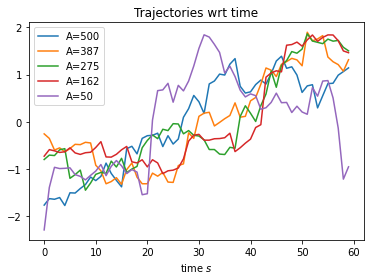

In [26]:
y1 = np.zeros(N)
x1 = np.zeros((N,L))
for n in np.linspace(500,50,5):
    plt.plot(traj(x1,y1,n)[0][0], label="A=%i" %n)
plt.title('Trajectories wrt time')
plt.xlabel('time $s$')
plt.legend()

In this way we represent the different trajectories created with various values of the amplitude A. In particular we see the firs trajectory $x_{0}$ for each amplitude. 

What is the value of A i would expect the network starts to fail recognizing the categories of bumps in trajectories?



In [27]:
def preprocessing(x,y,A,perc_train = 0.8,L=60):
    # da mettere dentro l'altra funzione delle traiettorie 
    N_train = int(N * perc_train)
    N_val = N - N_train
    # using the function whose results are the trajectories and the labels
    x1 = traj(x,y,A)[0]
    y2 = traj(x,y,A)[1]

    # dividing samples into training and test set  
    x_train1 = x1[:N_train]
    y_train1 = y2[:N_train]
    x_val1 = x1[N_train:]
    y_val1 = y2[N_train:]

    # reshaping the data to fit the model
    x_train1 = x_train1.reshape(x_train1.shape[0],L,1)
    x_val1 = x_val1.reshape(x_val1.shape[0],L,1)
    return x_train1,y_train1,x_val1,y_val1

In [28]:
def compile_model():
    reg = regularizers.l1(0.01) # for the lambda in lasso regularization
    np.random.seed(12345)
    # it draws from a normal distribution
    ini = initializers.RandomNormal(mean=0, stddev= 0.05)

    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=11,
            kernel_regularizer = reg,
            kernel_initializer = ini,
            activation = "relu",
            input_shape = input_shape
            ))

    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ, activation="softmax"))

    opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    return model 

In [29]:
# definisco una lista di score ottenuti a partire dai fit con diversi A
score_A_train_test = []

y1 = np.zeros(N)
x1 = np.zeros((N,L))
A_list = [500. , 387.5, 275. , 162.5,  50. ]

# computing a sort of gridsearch for the amplitude values
for n in A_list:
    x_train1,y_train1,x_val1,y_val1 = preprocessing(x1,y1,n,perc_train = 0.8,L=60)

    fit_A = compile_model().fit(x_train1, y_train1, batch_size=batch_size, epochs=50, validation_data=(x_val1,y_val1), verbose=0, shuffle=True)
    # così poche epochs perchè a noi interessa vedere dove inizia a FALLIRE il modello quindi già all'inizio la loss potrebbe essere molto elevata per quei casi in cui il modello non riesce a riconoscere le traiettorie sinusoidali
    score_A_train_test.append((fit_A.history['accuracy'][-1],fit_A.history['val_accuracy'][-1])) # gli ultimi valori all'epoch 50 di accuratezza sul training e sul test set 


In [30]:
score_A_train_test

[(0.6349999904632568, 0.6265000104904175),
 (0.4762499928474426, 0.534500002861023),
 (0.3948749899864197, 0.39649999141693115),
 (0.32862499356269836, 0.3330000042915344),
 (0.3332499861717224, 0.3334999978542328)]

In [31]:
# the worst A value is collected from the tuples of the previous cell. Each row correspond to the training and test accuracy on the network for a different A value

A_worst = A_list[np.argmin(score_A_train_test)//2]

In [32]:
def draw_normalized_confusion_matrix(x_set, y_set, keras_model, labels = ["absent","negative","positive"], verbose=False) :
    from sklearn.metrics import confusion_matrix
    import seaborn as sns 
    #np.set_printoptions(precision=2, suppress=True)

    counts = np.sum(y_set, axis=0)
    confusion_nn = confusion_matrix(y_set.argmax(axis=1), keras_model.predict(x_set).argmax(axis=1))/counts[:,None]

    if verbose :
        print("Labels and frequencies in test set:\n", labels, "\n", counts)
        print("text confusion matrix:\n",confusion_nn)

    fig, ax1 = plt.subplots(1,1, figsize=(10,10))
    ax1 = sns.heatmap(confusion_nn, square=True, annot=True, cbar=False, cmap='GnBu', xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('CNN Confusion Matrix')
    ax1.set_xlabel('true label')
    ax1.set_ylabel('predicted label')

In [33]:
# computing the fit explicitly for thew worst A value
y2 = np.zeros(N)
x2 = np.zeros((N,L))
x_train_cm,y_train_cm,x_val_cm,y_val_cm = preprocessing(x2,y2,A_worst,perc_train = 0.8,L=60)

model_cm = compile_model()

Labels and frequencies in test set:
 ['absent', 'negative', 'positive'] 
 [667. 666. 667.]
text confusion matrix:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


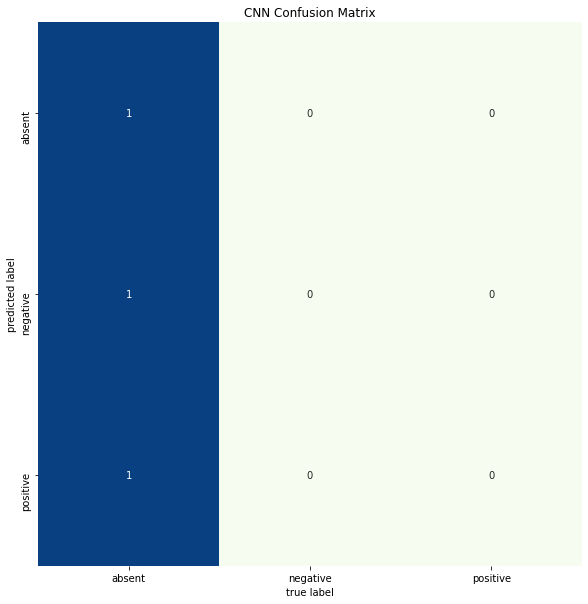

In [34]:
draw_normalized_confusion_matrix(x_val_cm, y_val_cm,model_cm, labels = ["absent","negative","positive"], verbose=True)

In [35]:
a = model.predict(x_val).argmax(axis=1)
b = y_val.argmax(axis=1)

In [36]:
a[(a == 0) & (a == b)].shape[0]/667

0.6491754122938531

In [37]:
a[(a == 1) & (a == b)].shape[0]/666

0.9204204204204204

In [38]:
c = model_cm.predict(x_val_cm).argmax(axis=1)
d = y_val_cm.argmax(axis=1)

In [39]:
c[(c == 0) & (c == d)].shape[0]/667

1.0

In [40]:
c[(c == 1) & (c == d)]

array([], dtype=int64)

### Considerations

After these calculations we verified the truth of the confusion matrix both for the initial model trained with $A=500$ and for the last one with $A=162.5$. We noticed that, running different times the confusion matrix with the new samples, the model manages to recognize only 1/3 of the data. Indeed accuracy is about $\approx 0.33$. Since the classification is characterized by 3 categories it means that the CNN has 1/3 probability to correctly classify the samples, therefore it corresponds to a kind of randomly weighted network with no power of classification.

# Part 3

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers
from keras import initializers,regularizers
from math import sqrt

## Preprocessing


Number of total samples: 10000
Samples in the Training Set: 8000
Samples in Validation Set:2000
Length of each Sample:60


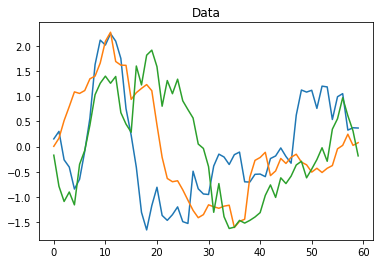

In [44]:
#filenames
str0="ts_comp_N10000"
fnamex = "x_"+str0+".csv"
fnamey = "y_"+str0+".csv"

#data
x = np.loadtxt(fnamex,delimiter=",",dtype=float)
N = len(x)

#we want to remove the average from each data
xm = x.mean(axis=1)
for n in range(N):
    x[n] = x[n] - xm[n] #data have now average 0
    
#remove the std and bring it back to 1
std = x.std(axis=1)
for n in range(N):
    x[n] = x[n] / std[n] #data have now average 0

#Labels
categ = np.loadtxt(fnamey,delimiter=",",dtype=int)
N_categ=3
y = np.zeros((N,N_categ))
for n in range(N):y[n][categ[n]] = 1 #one-hot encoding

#Training and Validation sets
perc_train = 0.8
N_train = int(N*perc_train)
N_val = N - N_train

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

L = len(x[0])

print(f"\nNumber of total samples: {N}\nSamples in the Training Set: {N_train}\nSamples in Validation Set:{N_val}\nLength of each Sample:{L}")

#reshape the data
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

#plot the data
plt.title("Data")
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

# CNN architectures

We want to find the best CNN architecture to properly solve our problem with this different set of data. The general requirements of these new CNNs are that:

* They must have **only one Convolutional layer** and as many Dense layers as we want.
* They must have the **number of total trainable parameters < 600**.

In order to look for the best architecture of the CNN, we defined several models with different number of hidden layers beside the convolutional one and we performed a Grid Search to select the best parameters for each model. All the combinations of parameters that we tried were previously checked to have a number of total trainable parameters smaller than 600.

## 1-hidden layer

In [45]:
#initialize empty list of best models
best_models = []
best_scores = []

np.random.seed(12345)
reg = regularizers.l1(1e-4) #lasso regularization
ini = initializers.RandomNormal(mean=0,stddev=0.05) #initialization of the weigths

#define the model
def create_model1(neurons, filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neurons,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [46]:
# create model
model1 = KerasClassifier(build_fn=create_model1, epochs=20, batch_size=50, verbose=0)

# define the grid search parameters
param_grid = [{'neurons':[10],'filters':[5],'kernel_size':[11]},
              {'neurons':[10],'filters':[5],'kernel_size':[17]},
              {'neurons':[15],'filters':[3],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.690750 using {'filters': 5, 'kernel_size': 17, 'neurons': 10}
0.607000 (0.049816) with: {'filters': 5, 'kernel_size': 11, 'neurons': 10}
0.690750 (0.016532) with: {'filters': 5, 'kernel_size': 17, 'neurons': 10}
0.582000 (0.081040) with: {'filters': 3, 'kernel_size': 11, 'neurons': 15}


## 2-hidden layer

In [47]:
#define the model
def create_model2(neuron1, neuron2, filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neuron1,activation="relu"))
    new_model.add(Dense(neuron2,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [48]:
# create model
model2 = KerasClassifier(build_fn=create_model2, epochs=20, batch_size=50, verbose=0)

# define the grid search parameters
param_grid = [{'neuron1':[5],'neuron2':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[8],'neuron2':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[5],'filters':[3],'kernel_size':[11]},
              {'neuron1':[15],'neuron2':[5],'filters':[5],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.641750 using {'filters': 5, 'kernel_size': 11, 'neuron1': 15, 'neuron2': 5}
0.598625 (0.081905) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 5, 'neuron2': 5}
0.546750 (0.026581) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 5}
0.572125 (0.061843) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 5}
0.641750 (0.036357) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 15, 'neuron2': 5}


## 3-hidden layer

In [49]:
#define the model
def create_model3(neuron1, neuron2, neuron3,filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neuron1,activation="relu"))
    new_model.add(Dense(neuron2,activation="relu"))
    new_model.add(Dense(neuron3,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [50]:
# create model
model3 = KerasClassifier(build_fn=create_model3, epochs=20, batch_size=50, verbose=0)

param_grid = [{'neuron1':[8],'neuron2':[8],'neuron3':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[8],'neuron3':[5],'filters':[3],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[8],'neuron3':[8],'filters':[3],'kernel_size':[11]}]
              
grid = GridSearchCV(estimator=model3, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
 
#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.607125 using {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 5}
0.574125 (0.025606) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 8, 'neuron3': 5}
0.607125 (0.058946) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 5}
0.576375 (0.045546) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 8}


## 4-hidden layers

In [51]:
#function that creates the model with tunable parameters
def create_model4(neurons1,neurons2,neurons3,neurons4,filters,kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))

    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    
    new_model.add(Dense(neurons1,activation="relu"))
    new_model.add(Dense(neurons2,activation="relu"))
    new_model.add(Dense(neurons3,activation="relu"))
    new_model.add(Dense(neurons4,activation="relu"))
    
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))
    
    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [52]:
#grisearch of best combination of parameters

# create model
model4 = KerasClassifier(build_fn=create_model4, epochs=20, batch_size=50, verbose=0)

# define the grid search parameters
param_grid = [{'neurons1':[5],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[5],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[10],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[5],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[10],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[7]},
              {'neurons1':[8],'neurons2':[8],'neurons3':[8],'neurons4':[8],'filters':[3],'kernel_size':[7]},
              {'neurons1':[8],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[5],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model4, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

print(best_models)
print(best_scores)

Best: 0.628250 using {'filters': 5, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.628250 (0.043837) with: {'filters': 5, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.599500 (0.073213) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 10, 'neurons2': 10, 'neurons3': 5, 'neurons4': 5}
0.582625 (0.062292) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 10, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.534125 (0.017108) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.559375 (0.044260) with: {'filters': 3, 'kernel_size': 7, 'neurons1': 10, 'neurons2': 10, 'neurons3': 5, 'neurons4': 5}
0.573125 (0.044973) with: {'filters': 3, 'kernel_size': 7, 'neurons1': 8, 'neurons2': 8, 'neurons3': 8, 'neurons4': 8}
0.602000 (0.032686) with: {'filters': 5, 'kernel_size': 11, 'neurons1': 8, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
[{'filters': 5, 'kernel_size': 17, 'neuron

After having found the best sets of parameters for the four different CNN architectures, we compared their performances and plotted the results.

The optimal parameters that we derived are:

* 1-layer: total trainable parameters=533
    * hidden layers=(15)
    * filters=3
    * kernel_size=11
      
* 2-layer: total trainable parameters=531
    * hidden layers=(5,5)
    * filters=5
    * kernel_size=11
           
* 3-layer: total trainable parameters=603
    * hidden layers=(8,8,5)
    * filters=5
    * kernel_size=11
* 4-layer: total trainable parameters=591
    * hidden layers=(8,5,5,5)
    * filters=5
    * kernel_size=11


In [53]:
batch_size = 50
epochs = 250

#define models with best parameters
model1=create_model1(**best_models[0])
model2=create_model2(**best_models[1])
model3=create_model3(**best_models[2])
model4=create_model4(**best_models[3])

#fit the models
fit1 = model1.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit2 = model2.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit3 = model3.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit4 = model4.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

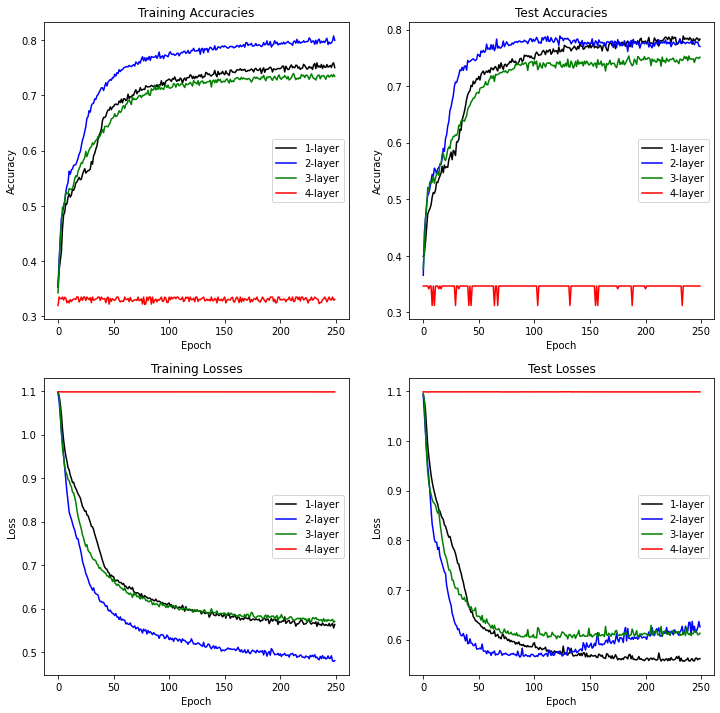

In [54]:
#evaluate performances
score1 = model1.evaluate(x_val, y_val, verbose=0)
score2 = model2.evaluate(x_val, y_val, verbose=0)
score3 = model3.evaluate(x_val, y_val, verbose=0)
score4 = model4.evaluate(x_val, y_val, verbose=0)

#plot
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

#Training Accuracy
ax[0,0].plot(fit1.history['accuracy'],color='black')
ax[0,0].plot(fit2.history['accuracy'],color='blue')
ax[0,0].plot(fit3.history['accuracy'],color='green')
ax[0,0].plot(fit4.history['accuracy'],color='red')
ax[0,0].set_title("Training Accuracies")
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Test Accuracy
ax[0,1].plot(fit1.history['val_accuracy'],color='black')
ax[0,1].plot(fit2.history['val_accuracy'],color='blue')
ax[0,1].plot(fit3.history['val_accuracy'],color='green')
ax[0,1].plot(fit4.history['val_accuracy'],color='red')
ax[0,1].set_title("Test Accuracies")
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Training Loss
ax[1,0].plot(fit1.history['loss'],color='black')
ax[1,0].plot(fit2.history['loss'],color='blue')
ax[1,0].plot(fit3.history['loss'],color='green')
ax[1,0].plot(fit4.history['loss'],color='red')
ax[1,0].set_title("Training Losses")
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Test Loss
ax[1,1].plot(fit1.history['val_loss'],color='black')
ax[1,1].plot(fit2.history['val_loss'],color='blue')
ax[1,1].plot(fit3.history['val_loss'],color='green')
ax[1,1].plot(fit4.history['val_loss'],color='red')
ax[1,1].set_title("Test Losses")
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

plt.show()    

### Conclusion

From the images that we plotted, the most performing CNN architecture happens to be the one with **only one hidden layer** after the first convolutional one. The parameters that lead us to the best results are:

* Hidden Layer=(15)
* Filters=3
* Kernel_size=11

For this specific CNN configuration we obtained:
* Test Accuracy: 0.81
* Test Loss: 0.52

With 533 total trainable parameters.

When we were building the different models, we studied how the number of total trainable parameters varied when varying the number of hidden layers and the number of their neurons. We noticed that the presence of another Convolutional Layer guarantees that the total number of weights doesn't increase too fast, while when adding more Dense layers to the model we easily reach the maximum value of 600 total trainable parameters.

# Part 4

Keeping fixed the definition of the CNN model we want now play with the regularizer parameters (and other parameters)

In [55]:
#define the model
def create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.001, l2 = 0.001):
    
    np.random.seed(12345)
    reg = regularizers.l1_l2(l1,l2) #lasso and ridge regularization
    #ini = initializers.RandomNormal(mean=0,stddev=sqrt(2/11)) #Kaiming initialization
    ini = initializers.RandomNormal(mean=0,stddev=0.05) #better results than above
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neurons,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [56]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=create_model1, 
                                   epochs=20, 
                                   batch_size=50, 
                                   verbose=0)

# list of allowed optional arguments for the optimizer, see compile_model()
l1 = [0.0001,0.001,0.01]
l2 = [0.0001,0.001,0.01]
# define parameter dictionary
param_grid = dict(l1=l1,l2=l2)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.652000 using {'l1': 0.0001, 'l2': 0.0001}
0.652000 (0.018997) with: {'l1': 0.0001, 'l2': 0.0001}
0.510250 (0.012867) with: {'l1': 0.0001, 'l2': 0.001}
0.565625 (0.069963) with: {'l1': 0.0001, 'l2': 0.01}
0.604000 (0.084322) with: {'l1': 0.001, 'l2': 0.0001}
0.603250 (0.067447) with: {'l1': 0.001, 'l2': 0.001}
0.582750 (0.061283) with: {'l1': 0.001, 'l2': 0.01}
0.516875 (0.034481) with: {'l1': 0.01, 'l2': 0.0001}
0.527000 (0.026002) with: {'l1': 0.01, 'l2': 0.001}
0.541250 (0.073308) with: {'l1': 0.01, 'l2': 0.01}


### Visualization of results

In [57]:
batch_size = 50
epochs = 250

#define models with differents parameters
model1=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.0001, l2 = 0.01)
model2=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.01, l2 = 0.0001)
model3=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.001, l2 = 0.0001)
model4=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.01, l2 = 0.01)
model5=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.0001, l2 = 0.0001)

#fit the models
fit1 = model1.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit2 = model2.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit3 = model3.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit4 = model4.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit5 = model5.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

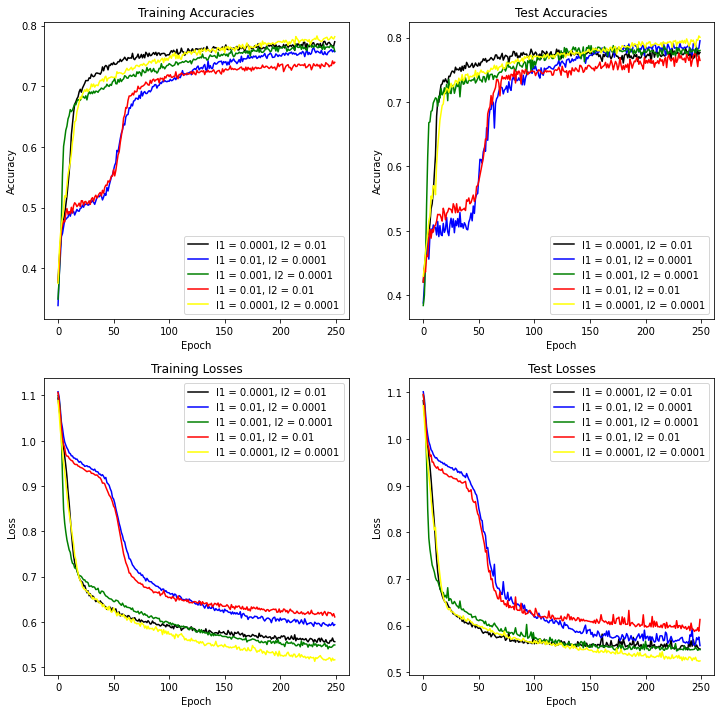

In [58]:
#evaluate performances
score1 = model1.evaluate(x_val, y_val, verbose=0)
score2 = model2.evaluate(x_val, y_val, verbose=0)
score3 = model3.evaluate(x_val, y_val, verbose=0)
score4 = model4.evaluate(x_val, y_val, verbose=0)
score5 = model5.evaluate(x_val, y_val, verbose=0)

#plot
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

#Training Accuracy
ax[0,0].plot(fit1.history['accuracy'],color='black')
ax[0,0].plot(fit2.history['accuracy'],color='blue')
ax[0,0].plot(fit3.history['accuracy'],color='green')
ax[0,0].plot(fit4.history['accuracy'],color='red')
ax[0,0].plot(fit5.history['accuracy'],color='yellow')
ax[0,0].set_title("Training Accuracies")
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

#Test Accuracy
ax[0,1].plot(fit1.history['val_accuracy'],color='black')
ax[0,1].plot(fit2.history['val_accuracy'],color='blue')
ax[0,1].plot(fit3.history['val_accuracy'],color='green')
ax[0,1].plot(fit4.history['val_accuracy'],color='red')
ax[0,1].plot(fit5.history['val_accuracy'],color='yellow')
ax[0,1].set_title("Test Accuracies")
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

#Training Loss
ax[1,0].plot(fit1.history['loss'],color='black')
ax[1,0].plot(fit2.history['loss'],color='blue')
ax[1,0].plot(fit3.history['loss'],color='green')
ax[1,0].plot(fit4.history['loss'],color='red')
ax[1,0].plot(fit5.history['loss'],color='yellow')
ax[1,0].set_title("Training Losses")
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

#Test Loss
ax[1,1].plot(fit1.history['val_loss'],color='black')
ax[1,1].plot(fit2.history['val_loss'],color='blue')
ax[1,1].plot(fit3.history['val_loss'],color='green')
ax[1,1].plot(fit4.history['val_loss'],color='red')
ax[1,1].plot(fit5.history['val_loss'],color='yellow')
ax[1,1].set_title("Test Losses")
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

plt.show()   

The grid search does not perform a good optimization, we should be repeat it with a larger numeber of epochs but this is computational expansive. So we see the plots for finding that the best intermediate regularization values for l1 and l2 are 0.01 and 0.0001:

* Test Accuracy: 0.80
* Test Loss: 0.57

The best result changing the regularization is about he same that befr

### Weights visualization

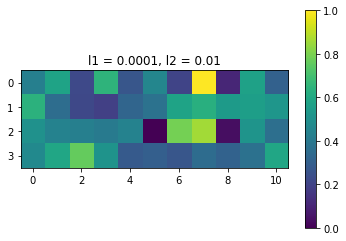

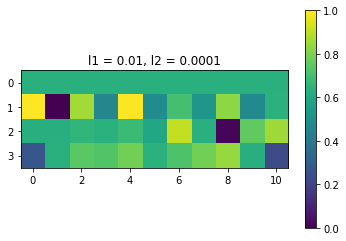

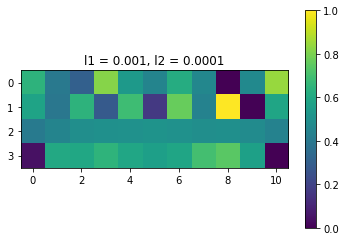

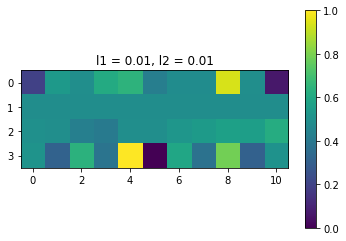

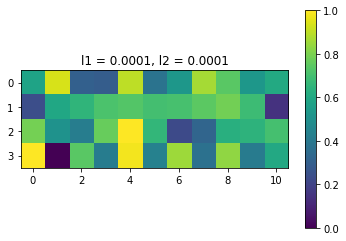

In [59]:
titles = ['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001']


i = 0
for models in [model1,model2,model3,model4,model5]:
    # check for convolutional layer

    layer = models.layers[0]
    # get filter weights
    filters, biases = layer.get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot filters

    plt.imshow(filters.T[:,0,:])
    plt.colorbar()
    plt.title(titles[i])
    plt.show()
    i += 1

We tried five different normalizations to plot the weights. Each normalization leads to completely different plots but the numerical results remain similar.
Each row of the plot corresponds also to one of the filter of weights.